**Assignment 10 - Google Play Store Dataset**

Author: BBBBB

Date: April 12, 2025

This script investigates the Google Play Store dataset, performs exploratory data analysis (EDA), and answers significant questions about the dataset, missing data handling, feature engineering, trends and strategic analysis was done.

In [144]:
# Libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from datetime import datetime
import statsmodels.api as sm
from matplotlib_venn import venn3

 # Q9. Load the Google Playstore dataset and examine its dimensions. How many rows and columns does the dataset have?

  The dataset has 14 columns and 10,840 rows.

In [145]:
# Load the flight price dataset and examine its dimensions.
df=pd.read_csv('googleplaystore.csv')
df.shape

(10841, 14)



---
**Before answering the next questions, let’s take a moment to clean up our dataset!**


In [146]:
df.head()

Unnamed: 0                                                App  \
0           0     Photo Editor & Candy Camera & Grid & ScrapBook   
1           1                                Coloring book moana   
2           2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
3           3                              Sketch - Draw & Paint   
4           4              Pixel Draw - Number Art Coloring Book   

         Category  Rating Reviews  Size     Installs  Type Price  \
0  ART_AND_DESIGN     4.1     159   19M      10,000+  Free     0   
1  ART_AND_DESIGN     3.9     967   14M     500,000+  Free     0   
2  ART_AND_DESIGN     4.7   87510  8.7M   5,000,000+  Free     0   
3  ART_AND_DESIGN     4.5  215644   25M  50,000,000+  Free     0   
4  ART_AND_DESIGN     4.3     967  2.8M     100,000+  Free     0   

  Content Rating                     Genres      Last Updated  \
0       Everyone               Art & Design   January 7, 2018   
1       Everyone  Art & Design;Pretend Play  January 15, 2018   
2       Everyone               Art & Design    August 1, 2018   
3           Teen               Art & Design      June 8, 2018   
4       Everyone    Art & Design;Creativity     June 20, 2018   

          Current Ver   Android Ver  
0               1.0.0  4.0.3 and up  
1               2.0.0  4.0.3 and up  
2               1.2.4  4.0.3 and up  
3  Varies with device    4.2 and up  
4                 1.1    4.4 and up

In [147]:
df.describe()

Unnamed: 0       Rating
count  10841.000000  9367.000000
mean    5420.000000     4.193338
std     3129.671468     0.537431
min        0.000000     1.000000
25%     2710.000000     4.000000
50%     5420.000000     4.300000
75%     8130.000000     4.500000
max    10840.000000    19.000000

In [148]:
# Drop Redundant Columns
df.drop(columns=["Unnamed: 0"], inplace=True)

In [149]:
# Check data type
df.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [150]:
# Check for Missing Values
print(df.isnull().sum())

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


**Correcting formatting**

In [151]:
# Correcting formatting

# Convert 'Reviews' to integer
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# Clean and Convert Size Column
def convert_size(size_str):
    if isinstance(size_str, str):  # Check if size_str is a string
        if "M" in size_str:
            return float(size_str.replace("M", ""))
        elif "k" in size_str:
            return float(size_str.replace("k", "")) / 1024
        else:
            return np.nan
    else:
        return size_str  # Return as is if not a string

df['Size_MB'] = df['Size'].replace("Varies with device", np.nan)
df['Size_MB'] = df['Size_MB'].apply(convert_size)

# Clean and Convert Installs Column
# Ensure the 'Installs' column is of type string before applying string methods
df['Installs'] = df['Installs'].astype(str)
df['Installs'] = df['Installs'].str.replace('+', '', regex=False).str.replace(',', '', regex=False)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Clean and Convert Price Column
df['Price'] = df['Price'].str.replace('$', '', regex=False)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Convert Last Updated to DateTime
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

In [152]:
# Check data type
df.dtypes

App                       object
Category                  object
Rating                   float64
Reviews                  float64
Size                      object
Installs                 float64
Type                      object
Price                    float64
Content Rating            object
Genres                    object
Last Updated      datetime64[ns]
Current Ver               object
Android Ver               object
Size_MB                  float64
dtype: object

**Handle missing values:**

In [153]:
# Check for Missing Values Again
print(df.isnull().sum())

App                  0
Category             0
Rating            1474
Reviews              1
Size                 0
Installs             1
Type                 1
Price                1
Content Rating       1
Genres               0
Last Updated         1
Current Ver          8
Android Ver          3
Size_MB           1696
dtype: int64


In [154]:
# Get rows with missing values in specified columns
missing_row = df[df[['Reviews', 'Installs', 'Type', 'Price', 'Content Rating', 'Last Updated', 'Current Ver', 'Android Ver']].isnull().any(axis=1)]
print(missing_row)

                                           App             Category  Rating  \
15             Learn To Draw Kawaii Characters       ART_AND_DESIGN     3.2   
1553                      Market Update Helper   LIBRARIES_AND_DEMO     4.1   
4453                    [substratum] Vacuum: P      PERSONALIZATION     4.4   
4490                      Pi Dark [substratum]      PERSONALIZATION     4.5   
6322                    Virtual DJ Sound Mixer                TOOLS     4.2   
6803                                 BT Master               FAMILY     NaN   
7333                               Dots puzzle               FAMILY     4.0   
7407                           Calculate My IQ               FAMILY     NaN   
7730                                    UFO-CQ                TOOLS     NaN   
9148                 Command & Conquer: Rivals               FAMILY     NaN   
10342                           La Fe de Jesus  BOOKS_AND_REFERENCE     NaN   
10472  Life Made WI-Fi Touchscreen Photo Frame      

In [155]:
# Drop rows with too many critical nulls or corrupted data
# Get the index labels of rows to drop based on the condition
rows_to_drop = df[df[['Reviews', 'Installs', 'Type', 'Price', 'Content Rating', 'Last Updated', 'Current Ver', 'Android Ver']].isnull().any(axis=1)].index

# Drop the rows using the obtained index labels
df.drop(index=rows_to_drop, inplace=True)

# Safely fill missing values in non-critical fields
df['Current Ver'] = df['Current Ver'].fillna('Unknown')
df['Android Ver'] = df['Android Ver'].fillna('Unknown')

# Fill rating with the mean
mean_rating = round(df['Rating'].mean(), 1)  # e.g., 4.2
df['Rating'] = df['Rating'].fillna(mean_rating)

# Impute missing Size_MB with the mean value for each Category
df['Size_MB'] = df.groupby('Category')['Size_MB'].transform(lambda x: x.fillna(x.mean()))

# Check for Missing Values Again
print(df.isnull().sum())

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
Size_MB           0
dtype: int64


**Handle duplicates**

In [156]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 483


In [157]:
# Remove duplicates
df = df.drop_duplicates()

**Feature Engineering**

In [158]:
# Make a copy to avoid change the original
df = df.copy()

# Convert 'Last Updated' to datetime
df.loc[:, 'Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

# Extract year, month, and day from 'Last Updated'
df['Year'] = df['Last Updated'].dt.year
df['Month'] = df['Last Updated'].dt.month
df['Day'] = df['Last Updated'].dt.day

**Validate Data Consistency**

In [159]:
df.describe()

Rating       Reviews      Installs         Price  \
count  10346.000000  1.034600e+04  1.034600e+04  10346.000000   
mean       4.189658  4.063338e+05  1.417266e+07      1.031561   
min        1.000000  0.000000e+00  0.000000e+00      0.000000   
25%        4.100000  3.200000e+01  1.000000e+03      0.000000   
50%        4.200000  1.688500e+03  1.000000e+05      0.000000   
75%        4.500000  4.659825e+04  1.000000e+06      0.000000   
max        5.000000  7.815831e+07  1.000000e+09    400.000000   
std        0.484179  2.698179e+06  8.028090e+07     16.287252   

                        Last Updated       Size_MB          Year  \
count                          10346  10346.000000  10346.000000   
mean   2017-11-14 14:51:45.200077312     21.052490   2017.383433   
min              2010-05-21 00:00:00      0.008301   2010.000000   
25%              2017-09-04 06:00:00      5.700000   2017.000000   
50%              2018-05-20 00:00:00     14.000000   2018.000000   
75%              2018-07-19 00:00:00     28.000000   2018.000000   
max              2018-08-08 00:00:00    100.000000   2018.000000   
std                              NaN     21.114314      1.112255   

              Month           Day  
count  10346.000000  10346.000000  
mean       6.398415     15.619756  
min        1.000000      1.000000  
25%        5.000000      6.000000  
50%        7.000000     16.000000  
75%        8.000000     24.000000  
max       12.000000     31.000000  
std        2.605970      9.528305

In [160]:
# Type should be Free or Paid
print(df['Type'].unique())

['Free' 'Paid']


df.drop(columns=['Current Ver', 'Android Ver'], inplace=True)

**Outliers Detection**

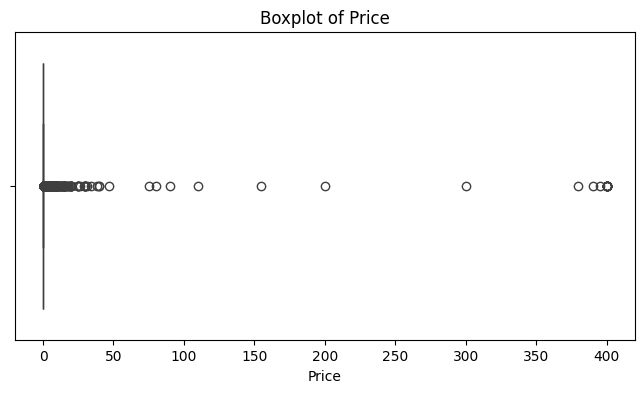

In [161]:
# Checking the outliers
features_to_check = ['Price']

for col in features_to_check:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [162]:
# Analyze the 'Price' column
df['Price'].value_counts().sort_index(ascending=True)


Price
0.00      9584
0.99       144
1.00         3
1.04         1
1.20         1
          ... 
379.99       1
389.99       1
394.99       1
399.99      12
400.00       1
Name: count, Length: 92, dtype: int64

The Price column contains a gigantic percentage of zeros for free applications, and this totally skew the distribution to the right. The extreme right skew ruins the mean and standard deviation, and it is hard to make an honest assessment of price trends. A lot of free applications also obscure valuable information about paid applications because their pricing patterns are swamped. In order to serve this, it is recommended to separate the analysis of free apps and paid apps. Separating paid apps will enable you to clearly examine trends, changes, and pricing without being influenced by zero-valued entries.

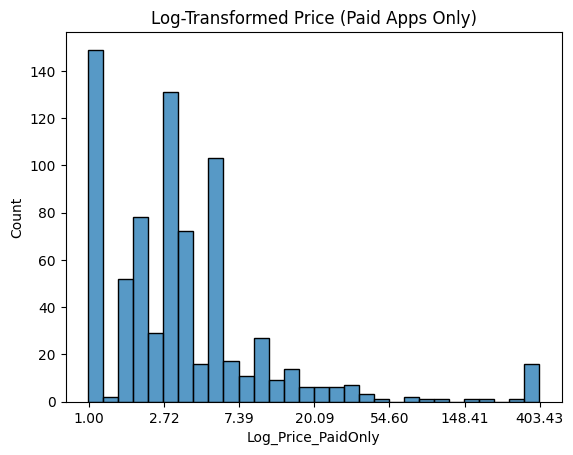

In [163]:
# Creating a new column
df['Price_PaidOnly'] = df['Price'].where(df['Type'] == 'Paid', np.nan)

df['Log_Price_PaidOnly'] = np.log(df['Price_PaidOnly'])

# Plotting the log-transformed Price (Paid Apps Only)
sns.histplot(df['Log_Price_PaidOnly'].dropna(), bins=30)

# Set the title
plt.title("Log-Transformed Price (Paid Apps Only)")

# Import FuncFormatter
from matplotlib.ticker import FuncFormatter

# Create a custom formatter for the x-axis
def log_transform_to_real(x, pos):
    """Convert log-transformed values back to original values for display."""
    return f'{np.exp(x):.2f}'  # Reverse the log transformation

# Apply the custom formatter to the x-axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_transform_to_real))

# Show the plot
plt.show()

**Encoding Categorical Variables**

In [164]:
unique_Content_Rating = df['Content Rating'].unique()

print("Unique Content Rating:", unique_Content_Rating)

# One-hot encode 'Category', 'Genres', 'Content Rating'
#df = pd.get_dummies(df, columns=['Content Rating'], drop_first=True)

Unique Content Rating: ['Everyone' 'Teen' 'Everyone 10+' 'Mature 17+' 'Adults only 18+' 'Unrated']


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10346 entries, 0 to 10840
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   App                 10346 non-null  object        
 1   Category            10346 non-null  object        
 2   Rating              10346 non-null  float64       
 3   Reviews             10346 non-null  float64       
 4   Size                10346 non-null  object        
 5   Installs            10346 non-null  float64       
 6   Type                10346 non-null  object        
 7   Price               10346 non-null  float64       
 8   Content Rating      10346 non-null  object        
 9   Genres              10346 non-null  object        
 10  Last Updated        10346 non-null  datetime64[ns]
 11  Current Ver         10346 non-null  object        
 12  Android Ver         10346 non-null  object        
 13  Size_MB             10346 non-null  float64       


# Q10. How does the rating of apps vary by category? Create a boxplot to compare the ratings of different app categories.

  Overall, app ratings across categories tend to fall within a relatively narrow range, typically between 3.8 and 4.6,  indicating user ratings of applications tend to be quite high, regardless of the category. That the Video Player category is one with the least average rating stands out, clustering at 4.4 and with lots more below, to suggest there may be user unrest in this market segment. On the other hand, the Art & Design category possesses one of the highest average ratings, approximately 4.4, and consists predominantly of ratings between 4.2 and 4.6. Additionally, while most of the ratings are clustered on the higher side, outliers, primarily on the lower side, are present in most categories, indicating the existence of poorly rated applications even in largely well-rated groups.

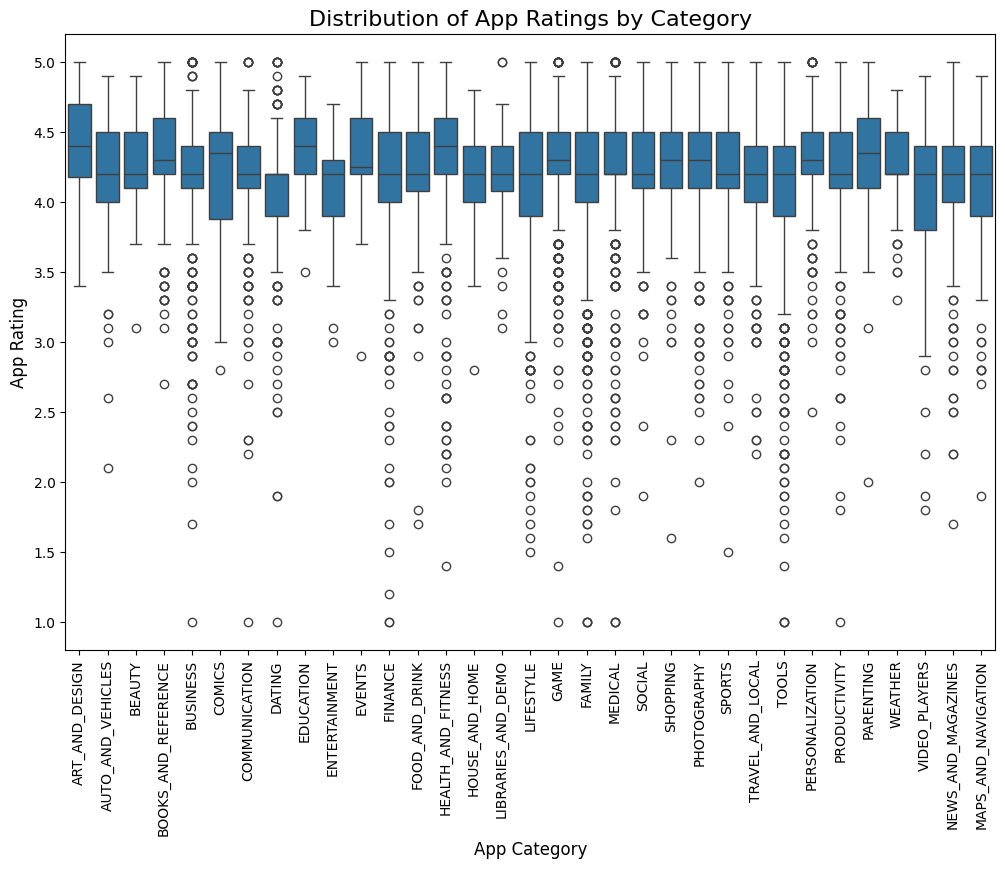

In [166]:
# Plot the rating and category
plt.figure(figsize=(12, 8))

# Create a boxplot to compare the ratings of different app categories
sns.boxplot(x='Category', y='Rating', data=df)

# Set the title and labels
plt.title('Distribution of App Ratings by Category', fontsize=16)
plt.xlabel('App Category', fontsize=12)
plt.ylabel('App Rating', fontsize=12)

# Rotate x labels for better readability if needed
plt.xticks(rotation=90)

# Show the plot
plt.show()

# Q11. Are there any missing values in the dataset? Identify any missing values and describe how they may impact your analysis.

Upon review of the dataset, there are some columns that contain missing values to be appropriately processed depending on how important they are to the analysis.
* Rating column contains 1,474 missing values and it is vital in questions Q10 and Q12, it has to be filled with the mean.
* All of the Reviews, Installs, and Last Updated fields contain a missing value only once, so deleting the single rows for these columns is reasonable, especially since Installs and Last Updated are necessary for Q14 and Q17 respectively.
* In Type, Price, and Content Rating, with one missing value each, deletion or imputation is acceptable; these are critical to Q13 and may have impact on categorical analysis.
* The Current Ver and Android Ver columns both contain a few missing values (8 and 3 respectively) and are not included directly in today's questions so could be excluded or filled in with something like "Unknown."
* Lastly, the Size_MB column contains 1,696 missing values but will be needed for Q12 so should be included for the present and it has to be filled with the mean value for each Category.

# Q12. What is the relationship between the size of an app and its rating? Create a scatter plot to visualize the relationship.

  Interestingly, there is no strong correlation between app size and user rating, larger apps are not more highly rated than smaller ones. Highly rated apps (around 4.5 to 5 stars) exist across all size ranges, suggesting that users value more than app size. This implies that developers may be best off optimizing for quality and user experience rather than just size. Overall, while app size and number of reviews provide context, they don't necessarily determine user satisfaction, supporting the compound nature of what makes a successful app.

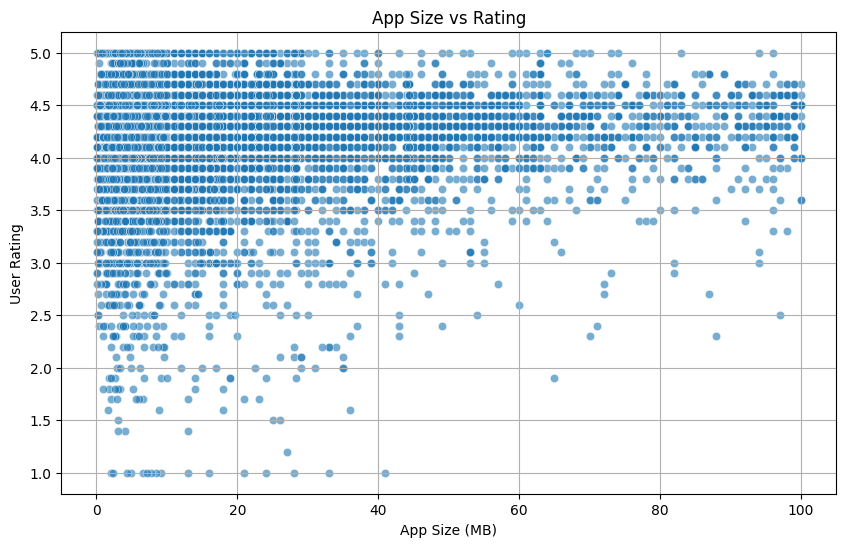

In [167]:
df_rating_size = df[['Size_MB', 'Rating']].dropna()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_rating_size, x='Size_MB', y='Rating', alpha=0.6)
plt.title('App Size vs Rating')
plt.xlabel('App Size (MB)')
plt.ylabel('User Rating')
plt.grid(True)
plt.show()

# Q13. How does the type of app affect its price? Create a bar chart to compare average prices by app type.
  To investigate the way prices vary across categories of apps, attention was limited to categories that contain at least one paid app. Categories comprised solely of free apps were automatically removed because they contain no price variation and therefore contribute nothing informative to the analysis. By screening in this way, the resulting chart displays average prices only for categories with paid apps, ensuring fair and accurate comparison free from the influence of the sheer multitude of free apps. By filtering this way, the Beauty, Comics, and House & Home categories were eliminated—not because they don't matter, but simply because they have no price fluctuation, and hence cannot assist in answering the question of how app prices fluctuate by category.

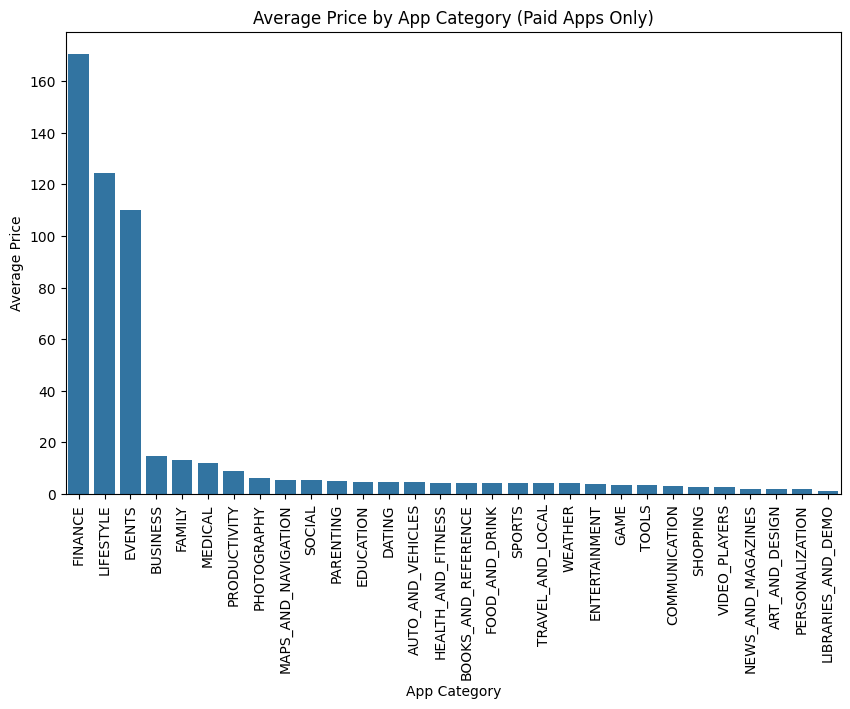

In [168]:
# Grouping by app type and calculating the average price for paid apps only
avg_price_by_type = df[df['Type'] == 'Paid'].groupby('Category')['Price'].mean()

# Plotting the bar chart
import seaborn as sns
import matplotlib.pyplot as plt

# Sorting for better visualization
avg_price_by_type = avg_price_by_type.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_price_by_type.index, y=avg_price_by_type.values)
plt.title("Average Price by App Category (Paid Apps Only)")
plt.xlabel("App Category")
plt.ylabel("Average Price")
plt.xticks(rotation=90)  # Rotate category labels for better readability
plt.show()

In [169]:
# All categories in the dataset
all_categories = set(df['Category'].unique())

# Categories that appear in the Paid Apps Only dataset
# Filter by 'Is_Free' column to get paid apps
paid_categories = set(df[df['Type'] == 'Paid']['Category'].unique())

# Categories that are only free apps
free_only_categories = all_categories - paid_categories

# Display the result
print("Categories that only have free apps (not shown in price plot):")
for category in sorted(free_only_categories):
    print("-", category)

Categories that only have free apps (not shown in price plot):
- BEAUTY
- COMICS
- HOUSE_AND_HOME


# Q14. What are the top 10 most popular apps in the dataset? Create a frequency table to identify the apps with the highest number of installs.


In [170]:
# Get the top 10 apps by installs
top_10_apps = df.sort_values('Installs', ascending=False).head(10)

# Ensure top_10_apps is a true copy
top_10_apps = top_10_apps.copy()

# Clean the 'Installs' column: remove commas, plus signs, and "Free"
# This line is modified to work with numeric or string data
top_10_apps['Installs'] = top_10_apps['Installs'].astype(str).str.replace(',', '', regex=False).str.replace('+', '', regex=False).str.replace('Free', '', regex=False)

# Convert to numeric (non-numeric values will become NaN)
top_10_apps['Installs'] = pd.to_numeric(top_10_apps['Installs'], errors='coerce')

# Format values with thousands separator
top_10_apps['Installs'] = top_10_apps['Installs'].apply(
    lambda x: f"{int(x):,}" if pd.notnull(x) else 'NaN'
)

# Reset index
top_10_apps.reset_index(drop=True, inplace=True)

# Show the cleaned DataFrame
top_10_apps

App            Category  Rating     Reviews  \
0              Google Photos         PHOTOGRAPHY     4.5  10847682.0   
1               Google Drive        PRODUCTIVITY     4.4   2728941.0   
2  Maps - Navigate & Explore    TRAVEL_AND_LOCAL     4.3   9235155.0   
3                   Hangouts       COMMUNICATION     4.0   3419464.0   
4                     Google               TOOLS     4.4   8033493.0   
5                Google News  NEWS_AND_MAGAZINES     3.9    878065.0   
6         Google Street View    TRAVEL_AND_LOCAL     4.2   2129689.0   
7              Google Photos         PHOTOGRAPHY     4.5  10859051.0   
8         Google Street View    TRAVEL_AND_LOCAL     4.2   2129707.0   
9  Maps - Navigate & Explore    TRAVEL_AND_LOCAL     4.3   9235373.0   

                 Size       Installs  Type  Price Content Rating  \
0  Varies with device  1,000,000,000  Free    0.0       Everyone   
1  Varies with device  1,000,000,000  Free    0.0       Everyone   
2  Varies with device  1,000,000,000  Free    0.0       Everyone   
3  Varies with device  1,000,000,000  Free    0.0       Everyone   
4  Varies with device  1,000,000,000  Free    0.0       Everyone   
5                 13M  1,000,000,000  Free    0.0           Teen   
6  Varies with device  1,000,000,000  Free    0.0       Everyone   
7  Varies with device  1,000,000,000  Free    0.0       Everyone   
8  Varies with device  1,000,000,000  Free    0.0       Everyone   
9  Varies with device  1,000,000,000  Free    0.0       Everyone   

             Genres Last Updated         Current Ver         Android Ver  \
0       Photography   2018-08-01  Varies with device  Varies with device   
1      Productivity   2018-07-30  Varies with device  Varies with device   
2    Travel & Local   2018-07-31  Varies with device  Varies with device   
3     Communication   2018-07-21  Varies with device  Varies with device   
4             Tools   2018-08-03  Varies with device  Varies with device   
5  News & Magazines   2018-08-01               5.2.0          4.4 and up   
6    Travel & Local   2018-08-06  Varies with device  Varies with device   
7       Photography   2018-08-06  Varies with device  Varies with device   
8    Travel & Local   2018-08-06  Varies with device  Varies with device   
9    Travel & Local   2018-07-31  Varies with device  Varies with device   

     Size_MB  Year  Month  Day  Price_PaidOnly  Log_Price_PaidOnly  
0  17.367574  2018      8    1             NaN                 NaN  
1  12.980885  2018      7   30             NaN                 NaN  
2  24.654463  2018      7   31             NaN                 NaN  
3  11.765673  2018      7   21             NaN                 NaN  
4   8.782017  2018      8    3             NaN                 NaN  
5  13.000000  2018      8    1             NaN                 NaN  
6  24.654463  2018      8    6             NaN                 NaN  
7  17.367574  2018      8    6             NaN                 NaN  
8  24.654463  2018      8    6             NaN                 NaN  
9  24.654463  2018      7   31             NaN                 NaN

# Q15. A company wants to launch a new app on the Google Playstore and has asked you to analyze the Google Playstore dataset to identify the most popular app categories. How would you approach this task, and what features would you analyze to make recommendations to the company?

  To identify the most trending categories of apps in Google Play Store, I would track key performance indicators such as installs volume, user rating, review volume, and pricing trends across categories. These metrics put together indicate user interest and engagement. Following the ranking of each category on the basis of its frequency in these indicators, categories like GAME and SOCIAL are the top performers, being ranked at the top in all four aspects being highly recommended choices for a new app launch. Categories like FAMILY, PHOTOGRAPHY, and PRODUCTIVITY are also among the top performers, especially in terms of installs and user engagement. By focusing on these top-performing categories, the company can then position their new app strategically in locations with demonstrated demand from consumers and competitive responses.

In [171]:
# Creating the Tops
top_installs = df.groupby('Category')['Installs'].sum().sort_values(ascending=False).head(10)
top_ratings = df.groupby('Category')['Rating'].mean().sort_values(ascending=False).head(10)
top_reviews = df.groupby('Category')['Reviews'].sum().sort_values(ascending=False).head(10)
category_price_summary = df[df['Type'] == 'Paid'].groupby('Category')['Price'].mean().sort_values(ascending=False)

# Combine all unique top categories
# price_summary_categories is already an Index, no need to access .index again
all_top_categories = set(top_installs.index) | set(top_ratings.index) | set(top_reviews.index) | set(category_price_summary.index) # Changed price_summary_categories to category_price_summary.index

# Create the comparison DataFrame
comparison_df = pd.DataFrame(index=sorted(all_top_categories))
comparison_df.index.name = 'Category'

# Now correctly use pd.Series to map values
comparison_df['Top Installs'] = pd.Series(comparison_df.index.isin(top_installs.index), index=comparison_df.index).map({True: '✓', False: ''})
comparison_df['Top Ratings'] = pd.Series(comparison_df.index.isin(top_ratings.index), index=comparison_df.index).map({True: '✓', False: ''})
comparison_df['Top Reviews'] = pd.Series(comparison_df.index.isin(top_reviews.index), index=comparison_df.index).map({True: '✓', False: ''})
comparison_df['In Price Summary'] = pd.Series(comparison_df.index.isin(category_price_summary.index), index=comparison_df.index).map({True: '✓', False: ''}) # Use category_price_summary.index

# Optional: Add a score column (e.g., 1 point per checkmark)
comparison_df['Score'] = comparison_df[['Top Installs', 'Top Ratings', 'Top Reviews', 'In Price Summary']].apply(lambda row: row.eq('✓').sum(), axis=1)

comparison_df.sort_values(by='Score', ascending=False, inplace=True)

comparison_df

Top Installs Top Ratings Top Reviews In Price Summary  \
Category                                                                    
GAME                           ✓           ✓           ✓                ✓   
SOCIAL                         ✓           ✓           ✓                ✓   
FAMILY                         ✓                       ✓                ✓   
PHOTOGRAPHY                    ✓                       ✓                ✓   
PRODUCTIVITY                   ✓                       ✓                ✓   
PERSONALIZATION                            ✓           ✓                ✓   
COMMUNICATION                  ✓                       ✓                ✓   
VIDEO_PLAYERS                  ✓                       ✓                ✓   
TOOLS                          ✓                       ✓                ✓   
HEALTH_AND_FITNESS                         ✓                            ✓   
NEWS_AND_MAGAZINES             ✓                                        ✓   
EDUCATION                                  ✓                            ✓   
EVENTS                                     ✓                            ✓   
BOOKS_AND_REFERENCE                        ✓                            ✓   
ART_AND_DESIGN                             ✓                            ✓   
TRAVEL_AND_LOCAL               ✓                                        ✓   
SHOPPING                                               ✓                ✓   
PARENTING                                  ✓                            ✓   
ENTERTAINMENT                                                           ✓   
BEAUTY                                     ✓                                
AUTO_AND_VEHICLES                                                       ✓   
BUSINESS                                                                ✓   
DATING                                                                  ✓   
FINANCE                                                                 ✓   
FOOD_AND_DRINK                                                          ✓   
MAPS_AND_NAVIGATION                                                     ✓   
MEDICAL                                                                 ✓   
LIBRARIES_AND_DEMO                                                      ✓   
LIFESTYLE                                                               ✓   
SPORTS                                                                  ✓   
WEATHER                                                                 ✓   

                     Score  
Category                    
GAME                     4  
SOCIAL                   4  
FAMILY                   3  
PHOTOGRAPHY              3  
PRODUCTIVITY             3  
PERSONALIZATION          3  
COMMUNICATION            3  
VIDEO_PLAYERS            3  
TOOLS                    3  
HEALTH_AND_FITNESS       2  
NEWS_AND_MAGAZINES       2  
EDUCATION                2  
EVENTS                   2  
BOOKS_AND_REFERENCE      2  
ART_AND_DESIGN           2  
TRAVEL_AND_LOCAL         2  
SHOPPING                 2  
PARENTING                2  
ENTERTAINMENT            1  
BEAUTY                   1  
AUTO_AND_VEHICLES        1  
BUSINESS                 1  
DATING                   1  
FINANCE                  1  
FOOD_AND_DRINK           1  
MAPS_AND_NAVIGATION      1  
MEDICAL                  1  
LIBRARIES_AND_DEMO       1  
LIFESTYLE                1  
SPORTS                   1  
WEATHER                  1

# Q16. A mobile app development company wants to analyze the Google Playstore dataset to identify the most successful app developers. What features would you analyze to make recommendations to the company, and what data visualizations would you use to present your findings?

  In order to identify the most successful Google Play app developers, one would need to analyze metrics like installs, ratings, reviews, and update frequency, as well as category, price model, and content rating. Even without a Developer column, sorting top apps and looking at naming patterns can be used to deduce developer success.

For visuals, a Venn diagram offers a useful way to highlight apps or categories that are successful in more than one metric (installs, ratings, reviews). This can be used together with a treemap or stacked bar chart to show install share or revenue models by category to make the information visually interesting and easy to understand.

# Q17. A marketing research firm wants to analyze the Google Playstore dataset to identify the best time to launch a new app. What features would you analyze to make recommendations to the company, and what data visualizations would you use to present your findings?

  "Based on trends seen, there is a large spike in average installs and reviews during August, particularly for the Communication, Video Players, Photography, and Productivity types. July also has a high volume of activity for Social and Communication apps. Therefore, releasing consumer-oriented apps during July or August is recommended to gain optimum visibility and activity."

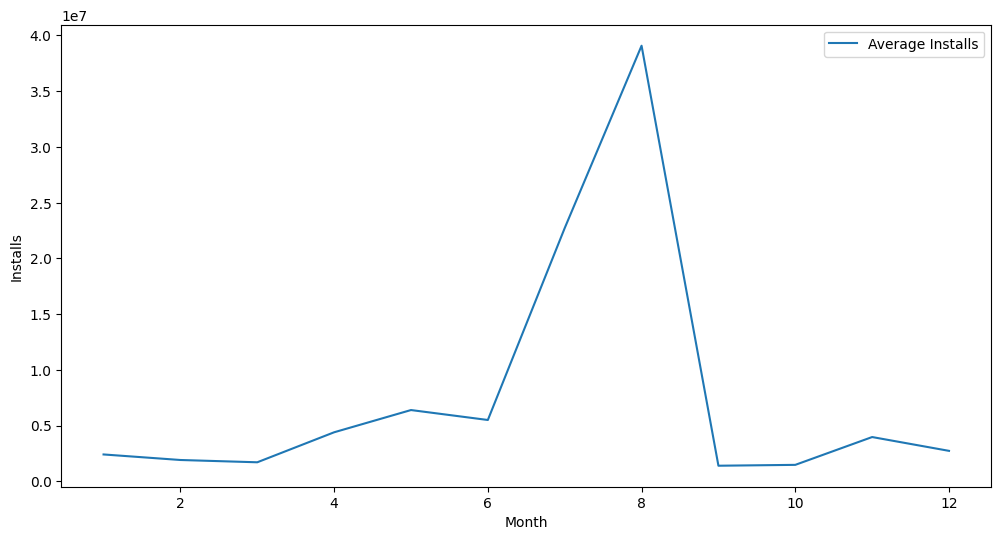

In [172]:
# Extracting the month and day for 'Last Updated'
df['Month'] = df['Last Updated'].dt.month
df['Year'] = df['Last Updated'].dt.year

#Group and Aggregate
monthly_summary = df.groupby('Month').agg({
    'Installs': 'mean',
    'Rating': 'mean',
    'Reviews': 'mean'
}).reset_index()

#Visualize Trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Installs', data=monthly_summary, label='Average Installs')
plt.show()


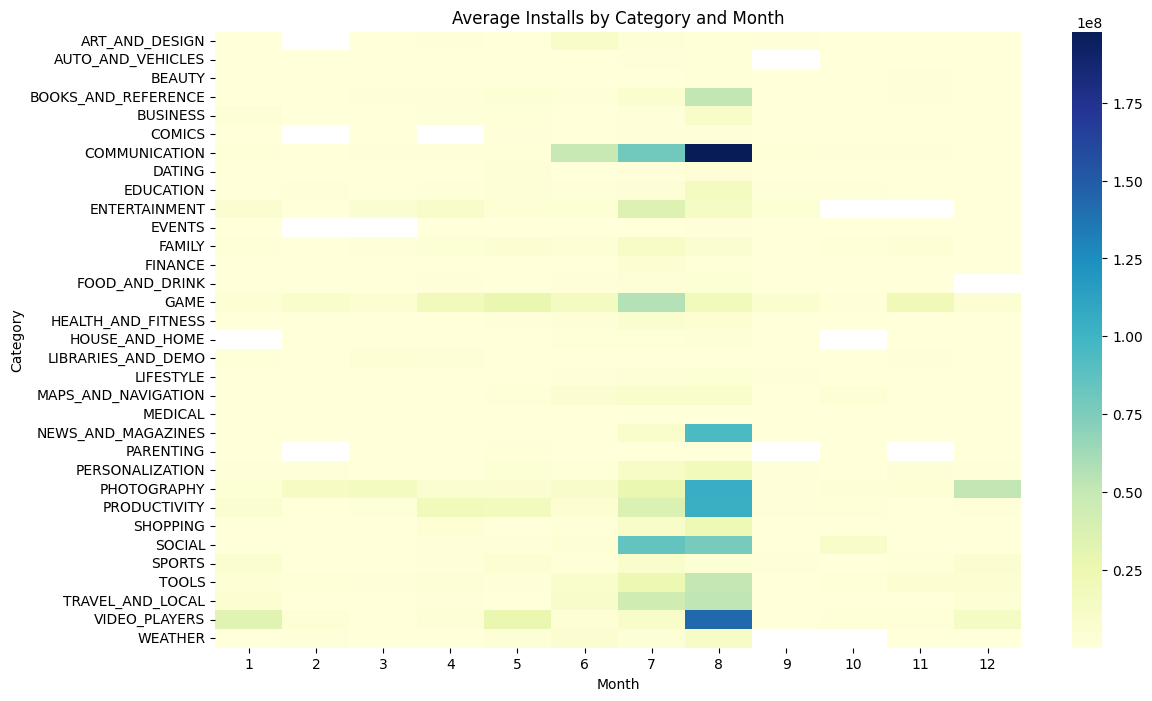

In [173]:
# Grouping by Category and Month
plt.figure(figsize=(13, 8))
category_month = df.groupby(['Category', 'Month'])['Installs'].mean().unstack()
sns.heatmap(category_month, cmap='YlGnBu')
plt.title('Average Installs by Category and Month')
plt.show()
#